In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
import arviz as az
import datetime

In [2]:
import fit_arima

### TO-DOs:

- Ripristinare la posterior_predictive (commentata nel codice STAN e non aggiornata per gestire le varie stazioni)
- Ripristinare la registrazione dei dati mancanti (commentata nel codice fit_arima.py e non aggiornata per gestire le varie stazioni)

## Day Planner
Il modello attualmente considerato è il seguente:

Definita la funzione $\text{sigmoide}$:
$$
\Sigma(z) = \frac{e^z - 1}{e^z + 1}
$$

Sia $s$ l'indice che scorre le stazioni:
$$
s \in \left\{ 1,\dots, S \right\}
$$
allora:
$$
\left. \mathbf{y}_s \right| \gamma_\theta, \underline{\gamma_\phi}, \sigma, \underline{\mu_\phi}, \underline{\sigma_\phi} \sim \text{ARIMA}_{2,1,1}\left( \Sigma(\gamma_{\phi,s}[0]), \Sigma(\gamma_{\phi,s}[1]), \Sigma(\gamma_\theta) , \sigma\right)\\
\left. \gamma_{\phi,s}[j] \right| \underline{\mu_\phi}, \underline{\sigma_\phi} \sim \mathcal{N}\left( \mu_{\phi}[j], \sigma_{\phi}[j] \right), \qquad j \in \left\{ 1,\dots,p \right\} = \left\{ 1,2 \right\}\\
\left. \gamma_\theta \right. \sim \mathcal{N}\left( 0,1 \right)\\
\left. \mu_\phi[j] \right. \sim \mathcal{N}\left( 0,5 \right) \qquad j \in \left\{ 1,\dots,p \right\}\\
\left. \sigma_\phi[j] \right. \sim \mathcal{IG}\left( 2.1,1.1 \right) \qquad j \in \left\{ 1,\dots,p \right\}
$$

L'ARIMA utilizza anche dati precedenti al giorno iniziale trattati come dati mancanti.
I dati mancanti in generale hanno bisogno di prior, che sono state scelte come segue:
$$
y[missing] \sim \mathcal{N}\left( 1,1 \right)
$$
(nel codice STAN sono la variabile 'w')

Tuttavia i dati precedenti i giorni iniziali sono stati trattati diversamente, secondo il modello:
$$
y_{start} | \mu_{start}, \sigma_{start} \sim \mathcal{N}\left( \mu_{start}, \sigma_{start} \right)\\
\mu_{start} \sim \mathcal{N}\left( 1,1 \right)\\
\sigma_{start} \sim \mathcal{IG}\left( 3,2 \right)
$$

Naturalmente se scrivessimo le cose per bene, la likelihood dell'ARIMA dovrebbe essere condizionata anche ai dati mancanti

In [3]:
import open_data
df = open_data.open()

Nel mio PC (br1) la porzione STAN del codice che segue è stata eseguita in ~ 26 minuti (da notare che prima di inserire le "hyper prior" che rendono il modello gerarchico, si ottenevano tempistiche di ~ 60 minuti)

(Sarebbe bello eseguire tutti il codice correggendo opportunamente in funzione dei core e segnare quanto ci vuole, quindi ad esempio con 4 core inserire catene=4 e samples_per_chain=1000, 6 core catene=6, samples = 750, il tempo da registrare sarebbe quello che appare a destra della barra di caricamento quando STAN termina la computazione)

In [4]:
ritorno = fit_arima.compute(2, 1, catene=8, samples_per_chain=500, burnin=500)

10:55:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

11:18:00 - cmdstanpy - INFO - CmdStan done processing.
11:18:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/br1/PythonProjects/bayesian_project/copie_temporanee/bayes_colab/ARIMA_STAN_matrices/code.stan', line 141, column 4 to column 34)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/br1/PythonProjects/bayesian_project/copie_temporanee/bayes_colab/ARIMA_STAN_matrices/code.stan', line 141, column 4 to column 34)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/br1/PythonProjects/bayesian_project/copie_temporanee/bayes_colab/ARIMA_STAN_matrices/code.stan', line 141, column 4 to column 34)
	Exception: code_model_namespace::log_prob: phi[2][3] is -nan, but must be greater than or equal to -1.000000 (in '/home/br1/PythonProjects/bayesian_project/copie_temporanee/bayes_colab/ARIMA_STAN_matrices/code.stan', line 76, column 2 to column 47)


11:18:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 5 had 22 divergent transitions (4.4%)
	Chain 6 had 1 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


In [5]:
az.summary(ritorno['inference_data'], var_names=['theta','sigma','gamma_th', 'hyper_y_start_m', 'hyper_y_start_s', 'hyper_gamma_phi_m', 'hyper_gamma_phi_s'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],-0.962,0.002,-0.965,-0.957,0.000,0.000,4003.0,3313.0,1.00
sigma,0.165,0.001,0.164,0.167,0.000,0.000,6703.0,3188.0,1.00
gamma_th[0],-3.934,0.057,-4.036,-3.823,0.001,0.001,4003.0,3313.0,1.00
hyper_y_start_m[0],1.552,0.652,0.391,2.835,0.101,0.076,43.0,150.0,1.15
hyper_y_start_m[1],2.017,0.166,1.740,2.369,0.027,0.019,41.0,92.0,1.17
hyper_y_start_m[2],1.810,0.056,1.707,1.918,0.006,0.005,78.0,135.0,1.10
hyper_y_start_s[0],0.368,0.115,0.177,0.586,0.006,0.004,340.0,506.0,1.02
hyper_y_start_s[1],0.141,0.025,0.097,0.189,0.001,0.000,1642.0,2782.0,1.00
hyper_y_start_s[2],0.127,0.020,0.091,0.164,0.000,0.000,1656.0,1202.0,1.00
hyper_gamma_phi_m[0],1.678,0.035,1.615,1.745,0.001,0.001,1069.0,1858.0,1.01


array([[<AxesSubplot: ylabel='hyper_gamma_phi_m\n1'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='hyper_gamma_phi_s\n0'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='hyper_gamma_phi_s\n1'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='theta\n0'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: xlabel='hyper_gamma_phi_m\n0', ylabel='sigma'>,
        <AxesSubplot: xlabel='hyper_gamma_phi_m\n1'>,
        <AxesSubplot: xlabel='hyper_gamma_phi_s\n0'>,
        <AxesSubplot: xlabel='hyper_gamma_phi_s\n1'>,
        <AxesSubplot: xlabel='theta\n0'>]], dtype=object)

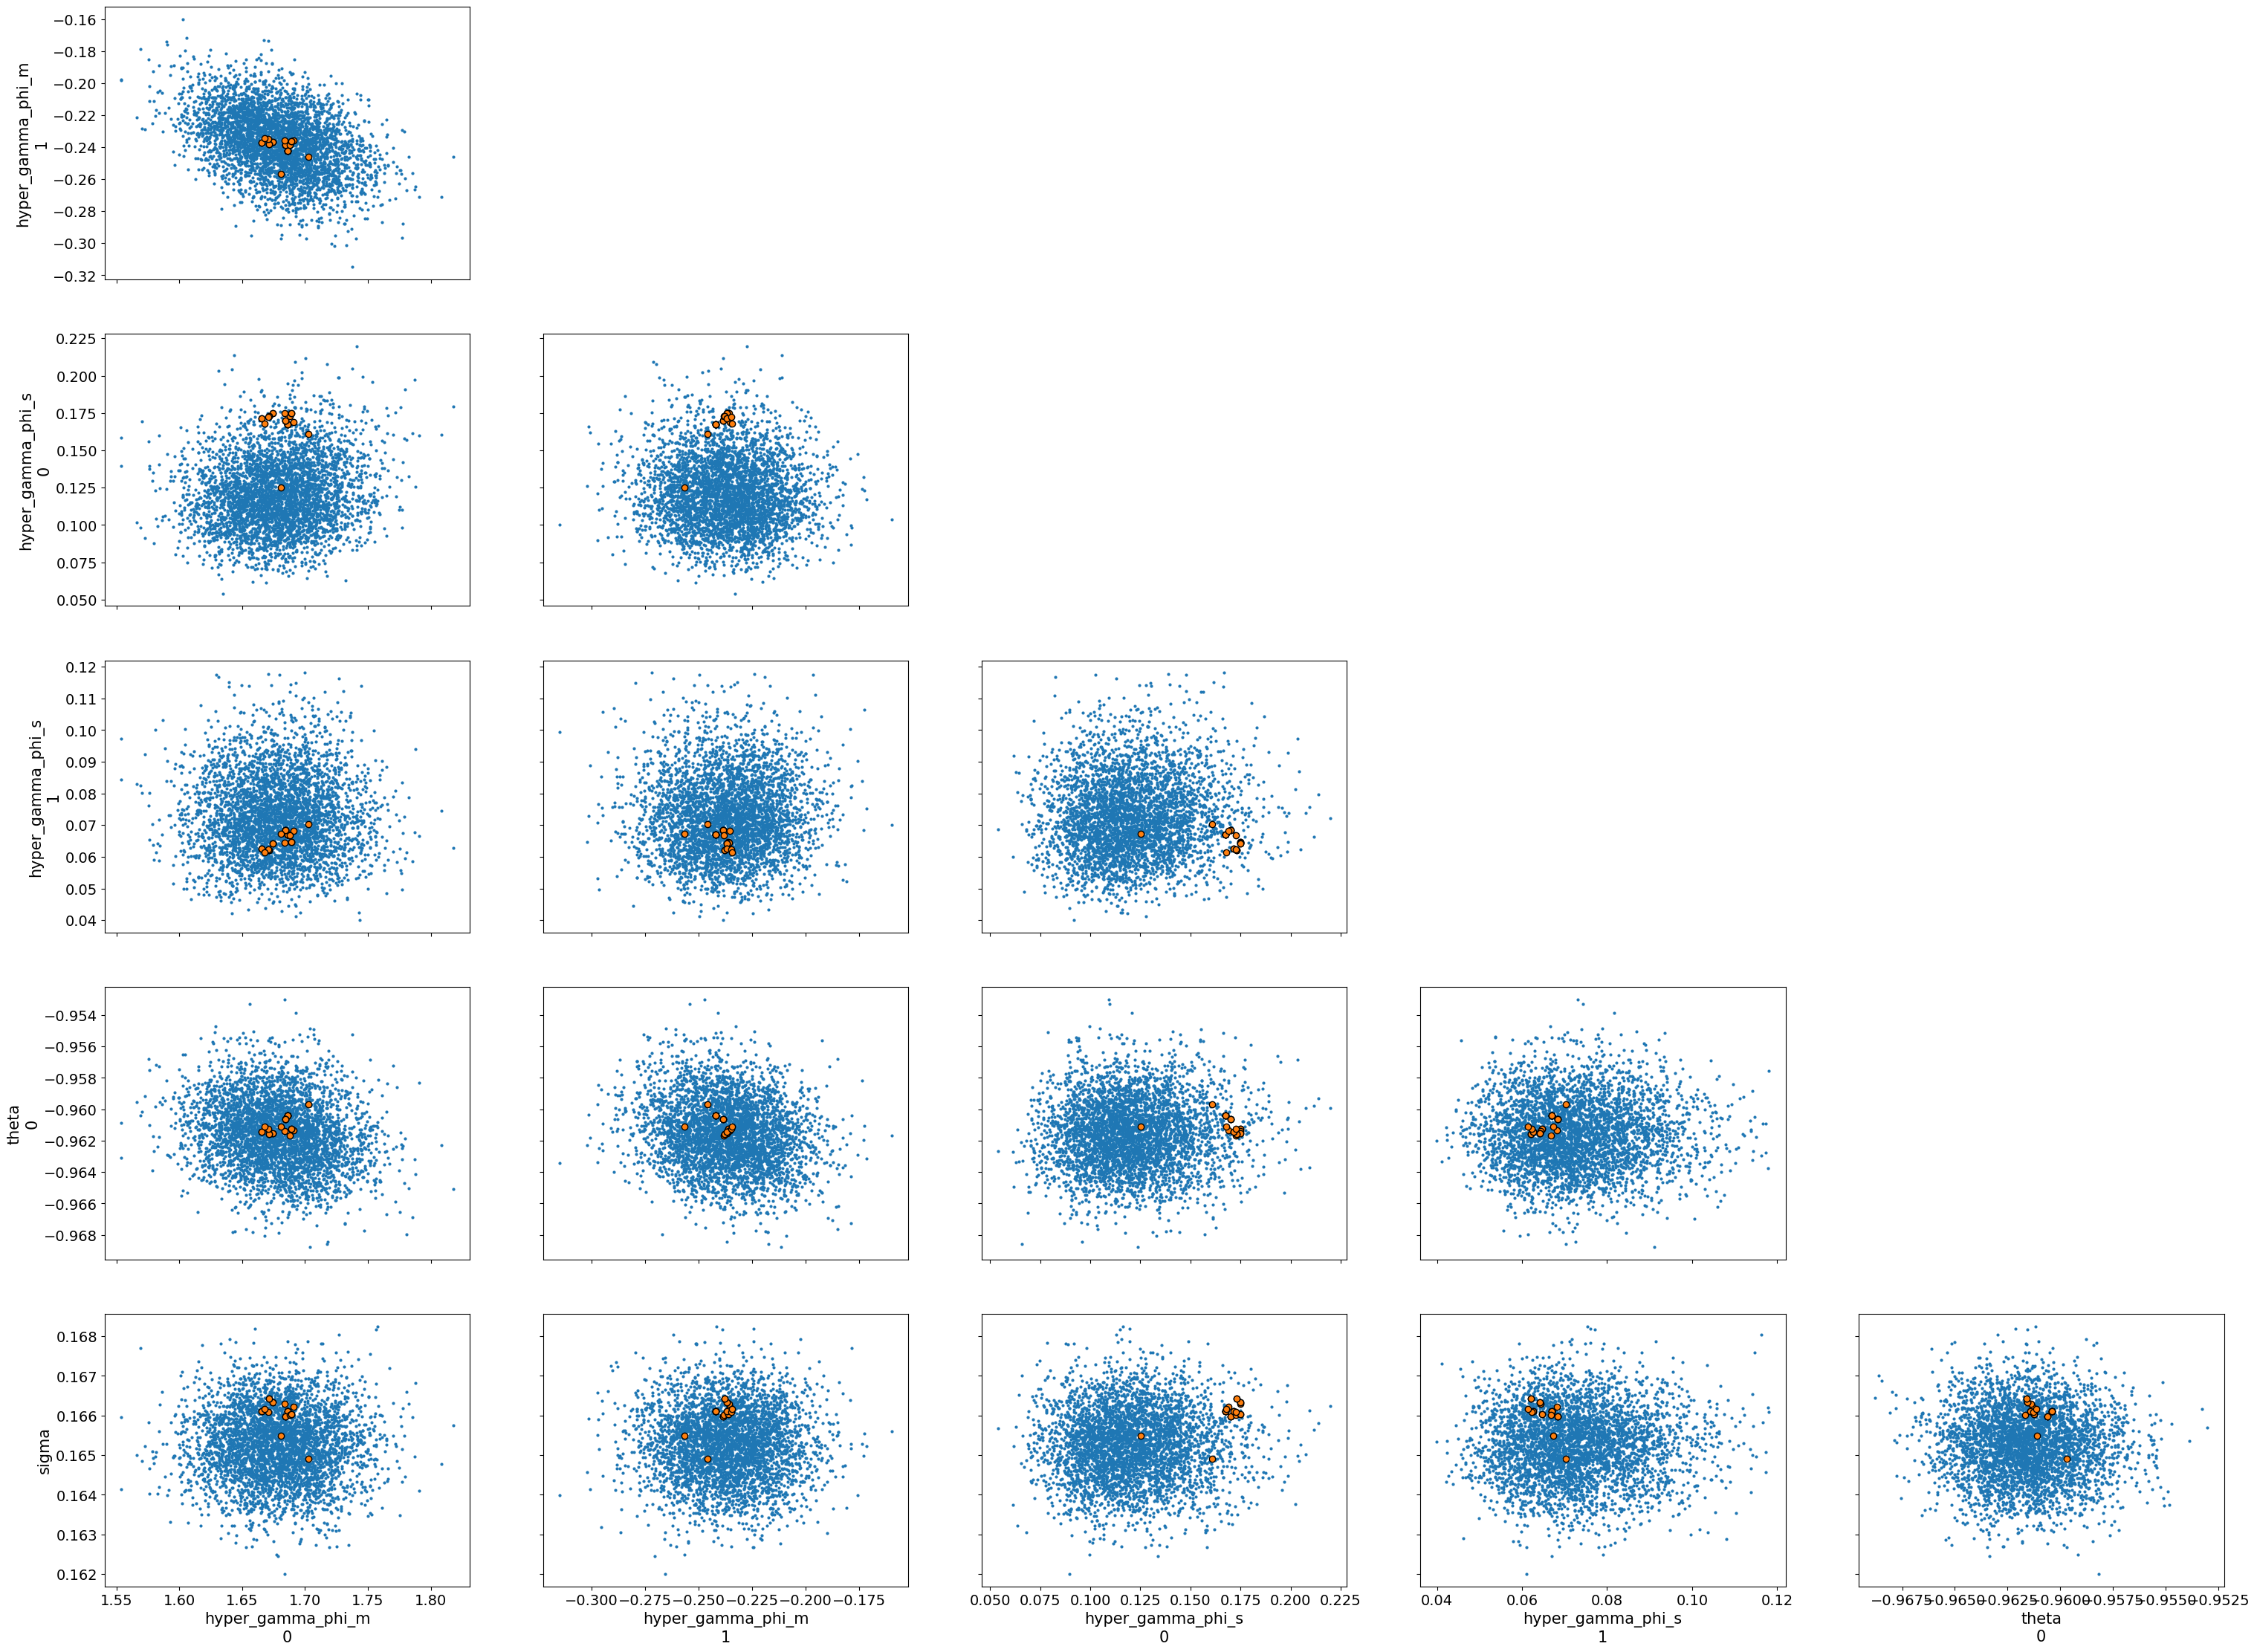

In [6]:
az.plot_pair(ritorno['inference_data'], var_names=['hyper_gamma_phi_m', 'hyper_gamma_phi_s', 'theta', 'sigma'], divergences=True)

array([[<AxesSubplot: title={'center': 'phi'}>,
        <AxesSubplot: title={'center': 'phi'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

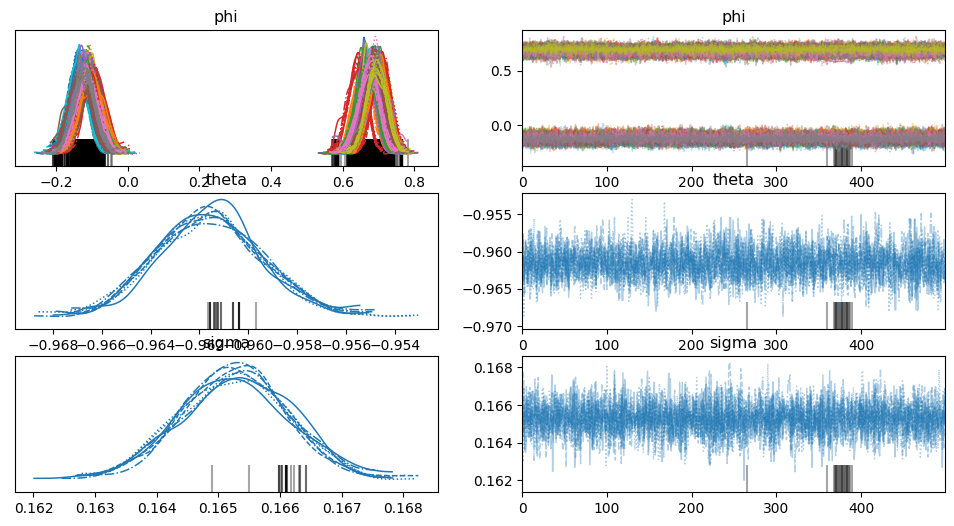

In [7]:
az.plot_trace(ritorno['inference_data'], var_names=['phi','theta','sigma'])

array([[<AxesSubplot: title={'center': 'theta\n0'}>,
        <AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'hyper_y_start_m\n0'}>],
       [<AxesSubplot: title={'center': 'hyper_y_start_m\n1'}>,
        <AxesSubplot: title={'center': 'hyper_y_start_m\n2'}>,
        <AxesSubplot: title={'center': 'hyper_y_start_s\n0'}>],
       [<AxesSubplot: title={'center': 'hyper_y_start_s\n1'}>,
        <AxesSubplot: title={'center': 'hyper_y_start_s\n2'}>,
        <AxesSubplot: title={'center': 'hyper_gamma_phi_m\n0'}>],
       [<AxesSubplot: title={'center': 'hyper_gamma_phi_m\n1'}>,
        <AxesSubplot: title={'center': 'hyper_gamma_phi_s\n0'}>,
        <AxesSubplot: title={'center': 'hyper_gamma_phi_s\n1'}>]],
      dtype=object)

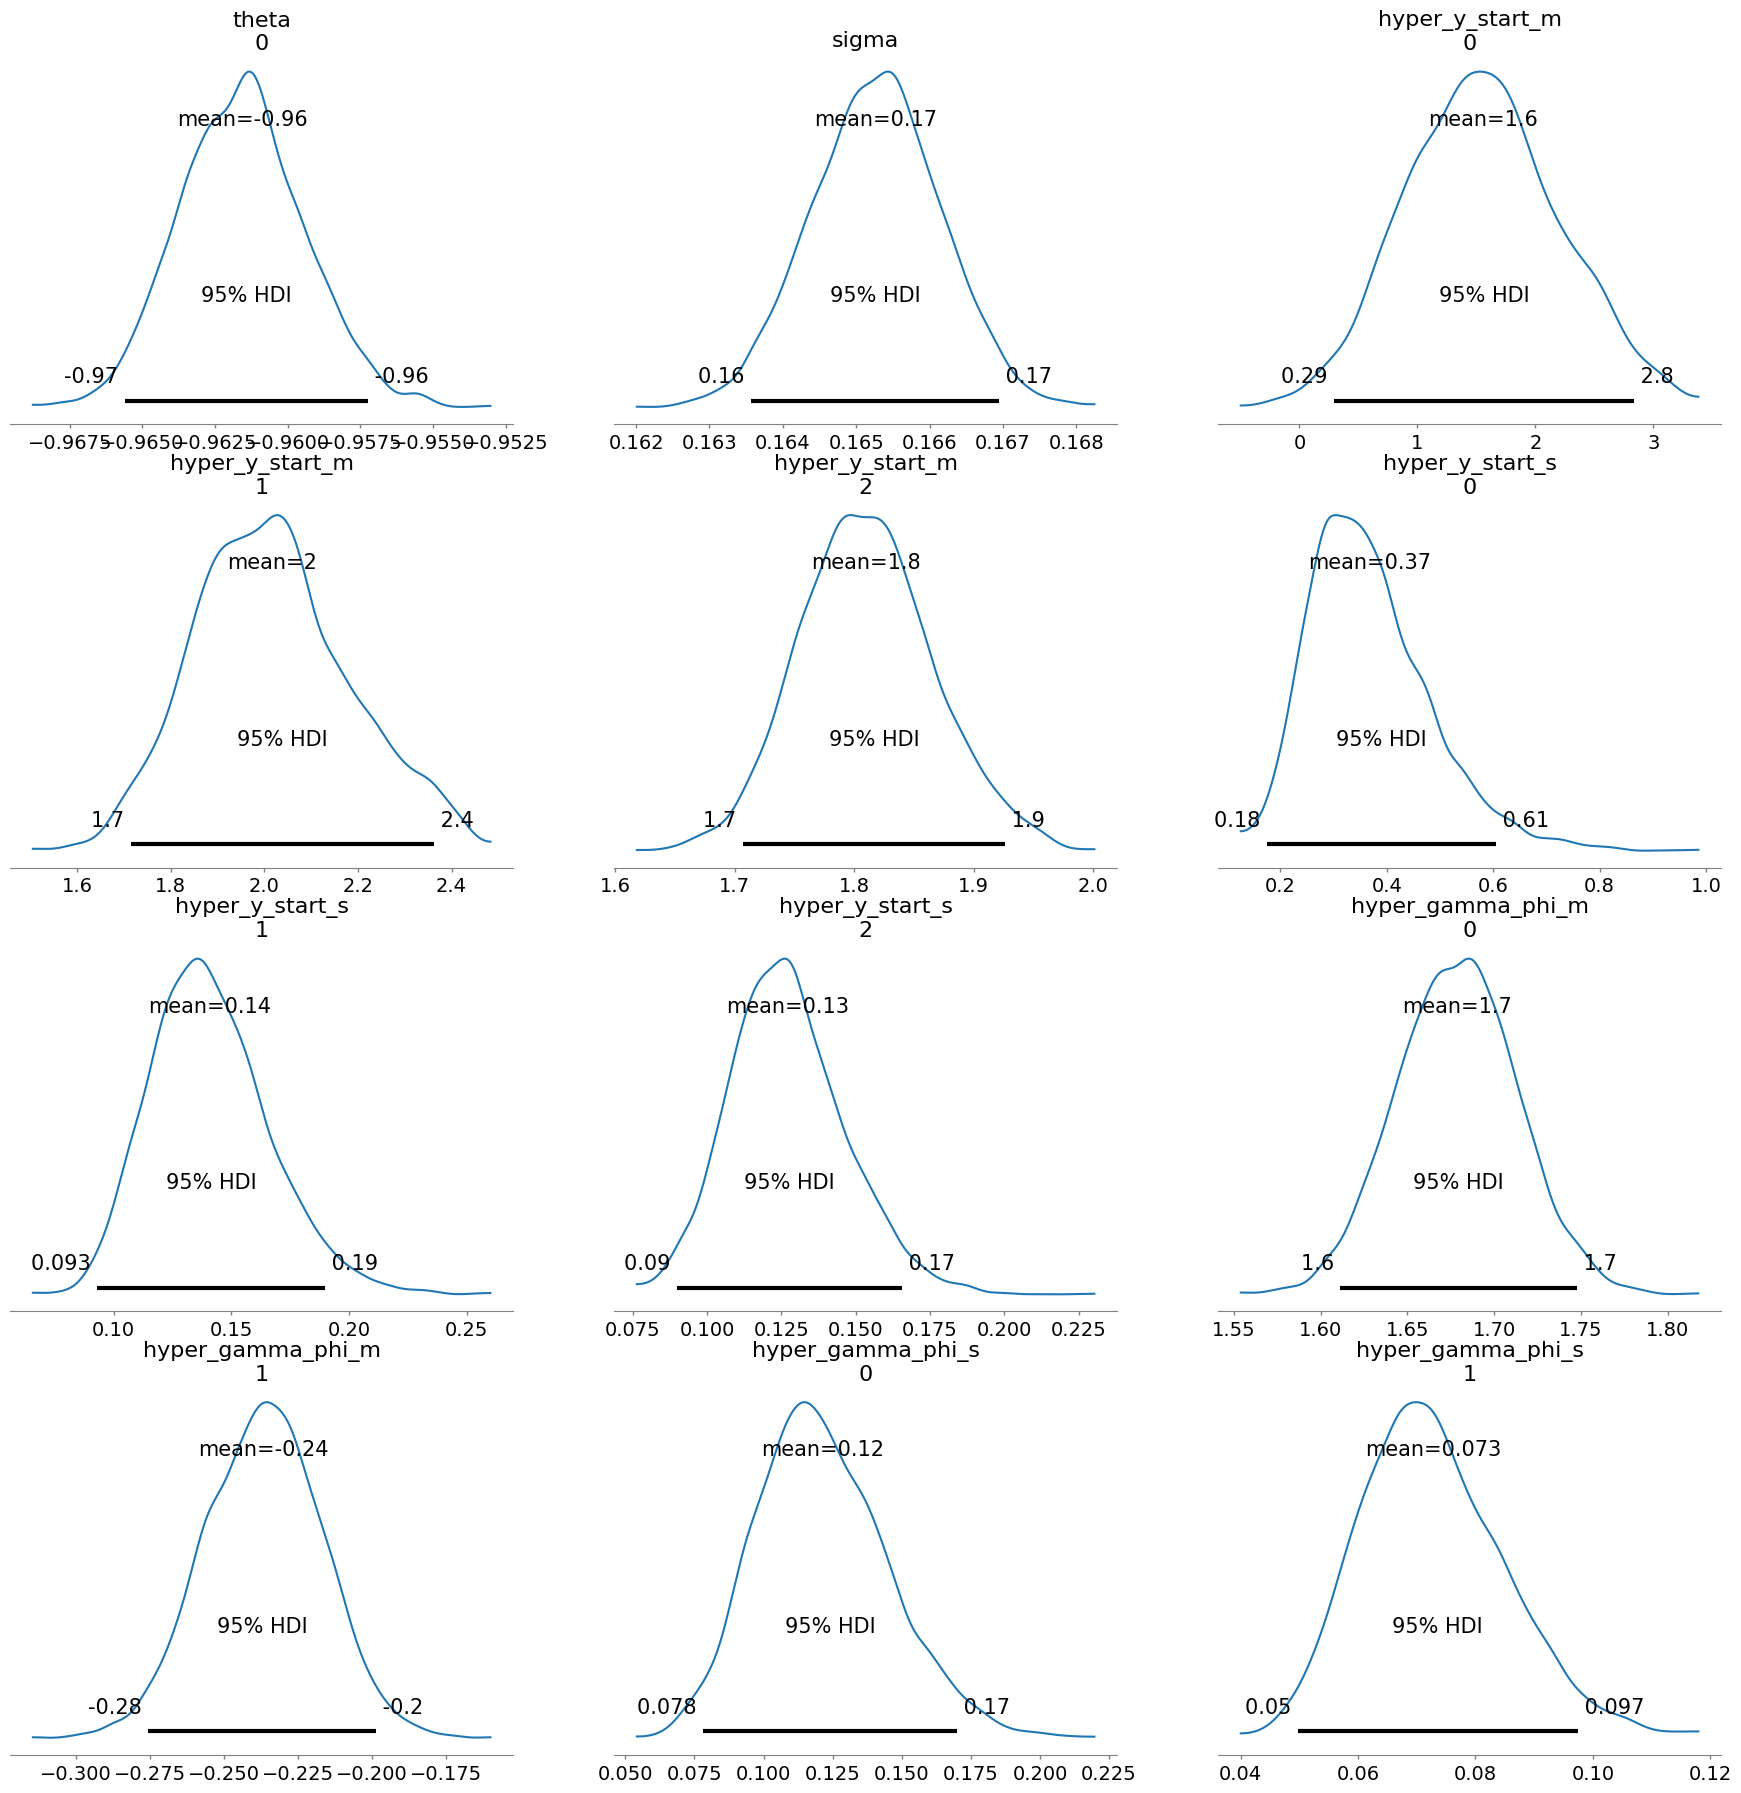

In [8]:
az.plot_posterior(ritorno['inference_data'], var_names=['theta','sigma','hyper_y_start_m','hyper_y_start_s', 'hyper_gamma_phi_m', 'hyper_gamma_phi_s'], hdi_prob=0.95)

<AxesSubplot: ylabel='Density'>

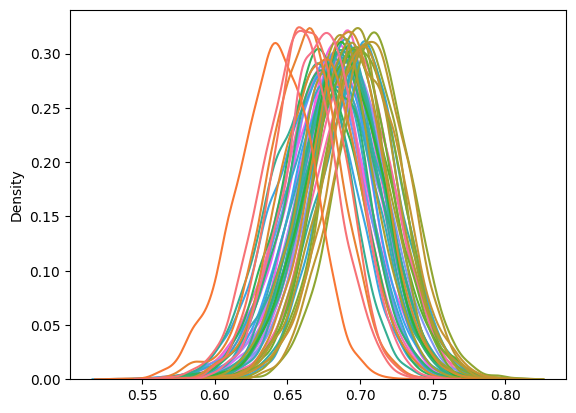

In [9]:
aux_shape = ritorno['inference_data'].posterior.phi.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.phi.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2],aux_shape[3]))[:,0,:], legend=False)

<AxesSubplot: ylabel='Density'>

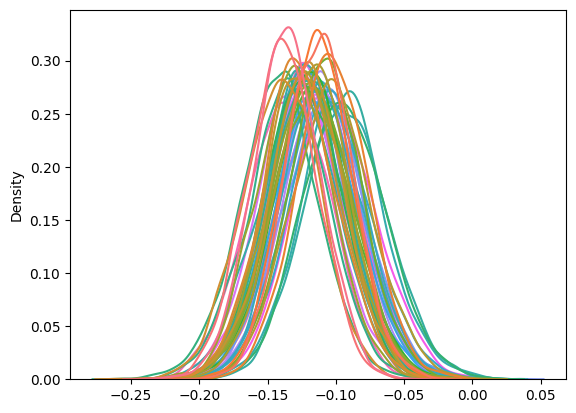

In [10]:
aux_shape = ritorno['inference_data'].posterior.phi.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.phi.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2],aux_shape[3]))[:,1,:], legend=False)

In [11]:
y_post_pred = ritorno['inference_data'].posterior.y_post_pred.to_numpy()
y_post_pred = y_post_pred.reshape(y_post_pred.shape[0]*y_post_pred.shape[1], y_post_pred.shape[2], y_post_pred.shape[3])
y_post_pred.shape

(4000, 365, 49)

In [12]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

In [18]:
@widgets.interact(stazione = df.columns)
def f(stazione):
    col_map = sns.light_palette((20, 75, 70), input='husl', as_cmap=True)

    plt.figure(figsize=(14,8))
    ax = plt.subplot(1,1,1)

    idx_stazione = df.columns.to_list().index(stazione)
    
    """
    sns.lineplot(np.transpose(y_post_pred[0:50,:,idx_stazione]))
    """

    lower_lim = np.zeros(len(df.index))
    upper_lim = np.zeros(len(df.index))    
    for i in range(len(df.index)):
        lower_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],2.5)
        upper_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],97.5)
    
    
#    sns.lineplot(lower_lim)
#    sns.lineplot(upper_lim)
    
    for i in range(len(df.index)):
        ax.add_patch(mplt.patches.Rectangle((i,lower_lim[i]),1,upper_lim[i]-lower_lim[i], fill=True, color=col_map(180)))

    sns.lineplot(df[stazione])    
    sns.lineplot(np.mean(y_post_pred[:,:,idx_stazione], axis=0))


    index = 0
    for line in ax.get_lines():
        if index == 0:
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(155))
        else:
            col_map = sns.dark_palette((10,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
        index += 1
        
    plt.ylim(bottom=0,top=2.5)

    primo_giorno = datetime.date(2018,1,1)
    date_da_segnare = []
    date_da_segnare_posizioni = []

    for i in range(12):
        date_da_segnare.append(datetime.date(2018,i+1,1))
        date_da_segnare_posizioni.append((date_da_segnare[2*i] - primo_giorno).days)
        date_da_segnare.append(datetime.date(2018,i+1,15))
        date_da_segnare_posizioni.append((date_da_segnare[2*i+1] - primo_giorno).days)
        date_da_segnare[2*i] = date_da_segnare[2*i].isoformat()
        date_da_segnare[2*i+1] = date_da_segnare[2*i+1].isoformat()

    plt.xticks(date_da_segnare_posizioni,date_da_segnare,rotation=65)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)
    plt.grid()
    
    """
    ax.get_legend().remove()
    col_vals = np.linspace(1,255,num=len(df.columns))
    index = 0
    for line in ax.get_lines():
        if(index == len(ax.get_lines()) - 1):
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            continue
        if(index == len(ax.get_lines()) - 2):
            col_map = sns.dark_palette((120,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            index += 1
            continue

        #line.set_c(col_map(int(np.round(col_vals[index]))))
        line.set_c(col_map(220))
        line.set_alpha(0.3)
        index += 1
    """
    
    

    plt.show()

interactive(children=(Dropdown(description='stazione', options=('CASTELLUCCIO', 'FEBBIO', 'CORTE BRUGNATELLA',…

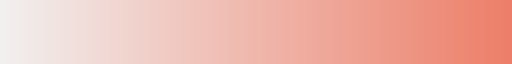

In [14]:
sns.light_palette((20,75,65), input='husl', as_cmap=True)